In [11]:
import pandas as pd
import numpy as np
from IPython.display import display
from os import listdir
sessions_df = pd.read_csv("data_toolkit/data/sessions.csv")
practices_df = pd.read_csv("data_toolkit/data/practices.csv")
ccgs_df = pd.read_csv("data_toolkit/data/ccgs.csv")

In [23]:
sessions_df.count()

id                      128618
practice_id             128618
posted_datetime         128618
start_datetime          128618
end_datetime            128618
hourly_rate             128618
original_hourly_rate     87316
status                  128618
locum_id                 47732
length_seconds          128618
is_short                128618
is_medium               128618
is_long                 128618
at_night                128618
at_afternoon            128618
at_morning              128618
dtype: int64

In [24]:
import datetime

length_seconds = lambda row: (row['end_datetime'] - row['start_datetime']).total_seconds()
one_hour = 60 * 60
is_short = lambda row: row['length_seconds'] <= 2 * one_hour
is_medium = lambda row: 2 * one_hour < row['length_seconds'] <= 4 * one_hour
is_long = lambda row: 4 * one_hour < row['length_seconds']


# These methods may exclude sessions that are very very long, but those
# appear to be outliers. Keeping it simple. 
def at_night(row): 
    return row['start_datetime'].time() >= datetime.time(18) or \
           row['end_datetime'].time() <= datetime.time(8)
   
   
def at_morning(row):
    start_in_morning = datetime.time(11) >= row['start_datetime'].time() >= datetime.time(6)
    end_in_morning = datetime.time(8) >= row['end_datetime'].time() >= datetime.time(12)
    if start_in_morning or end_in_morning:
        return True
    else:
        return False
    

def at_afternoon(row):
    start_in_aft = datetime.time(16) >= row['start_datetime'].time() > datetime.time(12)
    end_in_aft = datetime.time(20) >= row['end_datetime'].time() >= datetime.time(15)
    if start_in_aft or end_in_aft:
        return True
    else:
        return False
    
def is_on_day_of_week_partial(day_of_week):
    def is_on_day_of_week(row):
        if row['start_datetime'].weekday() == day_of_week:
            return True
        else:
            return False
    return is_on_day_of_week

In [25]:
# Transform data
# Add new features that come from the session time
sessions_df['start_datetime'] = pd.to_datetime(sessions_df['start_datetime'])
sessions_df['end_datetime'] = pd.to_datetime(sessions_df['end_datetime'])

sessions_df['length_seconds'] = sessions_df[['start_datetime', 'end_datetime']].apply(
    length_seconds, axis=1
)
sessions_df['is_short'] = sessions_df[['length_seconds']].apply(
    is_short, axis=1
)
sessions_df['is_medium'] = sessions_df[['length_seconds']].apply(
    is_medium, axis=1
)
sessions_df['is_long'] = sessions_df[['length_seconds']].apply(
    is_long, axis=1
)

sessions_df['at_night'] = sessions_df[['start_datetime', 'end_datetime']].apply(
    at_night, axis=1
)
sessions_df['at_afternoon'] = sessions_df[['start_datetime', 'end_datetime']].apply(
    at_afternoon, axis=1
)
sessions_df['at_morning'] = sessions_df[['start_datetime', 'end_datetime']].apply(
    at_morning, axis=1
)

sessions_df['monday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(0), axis=1
)
sessions_df['tuesday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(1), axis=1
)
sessions_df['wednesday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(2), axis=1
)
sessions_df['thursday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(3), axis=1
)
sessions_df['friday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(4), axis=1
)
sessions_df['saturday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(5), axis=1
)
sessions_df['sunday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(6), axis=1
)

In [26]:
# Clean data
# We care about Completed / Filled / Expired sessions
clean_df = sessions_df[
    (sessions_df.status == 'completed') |
    (sessions_df.status == 'expired') |
    (sessions_df.status == 'filled')
]
clean_df['filled'] = clean_df[['status']].apply(
    lambda row: row['status'] in ['completed', 'expired'], axis=1
)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
display(clean_df.describe())

,id,practice_id,hourly_rate,original_hourly_rate,locum_id,length_seconds
count,7.187300e+04,7.187300e+04,71873.000000,56544.000000,4.391500e+04,71873.000000
mean,3.686400e+08,2.139361e+06,81.944086,82.027766,1.522447e+07,17365.769379
std,1.033498e+08,1.279175e+06,7.199402,6.891379,5.001106e+07,8211.822889
min,4.016688e+07,3.011200e+04,60.000000,1.850000,2.011000e+04,7200.000000
25%,4.011212e+08,3.019170e+05,80.000000,80.000000,2.012139e+06,10800.000000
50%,4.011550e+08,3.011153e+06,80.000000,80.000000,2.013710e+06,14400.000000
75%,4.011850e+08,3.011767e+06,85.000000,85.000000,2.015509e+06,21600.000000
max,4.012203e+08,3.012808e+06,150.000000,150.000000,2.017111e+08,50400.000000


In [49]:
import matplotlib.pyplot as plt

rate_range = range(70, 130)


def print_count_graph(title, xs, filled, unfilled):
    ax = plt.subplot(111)
    filled_bar = ax.bar([x - 2 for x in xs], filled.values(), width=0.2, color='g', align='center')
    unfilled_bar = ax.bar([x + 0.2 - 2 for x in xs], unfilled.values(), width=0.2, color='r', align='center')
    ax.autoscale(tight=True)
    fig = ax.figure
    fig.set_size_inches((20, 10), forward=True)
    ax.set_ylabel("Number of sessions")
    ax.set_xlabel("Hourly rate")
    ax.legend((filled_bar, unfilled_bar), ("Filled sessions", "Unfilled sessions"))
    ax.set_xticks(xs)
    ax.set_title(title)
    plt.show()


def print_percentage_graph(title, xs, percentage):
    ax = plt.subplot(111)
    bars = []
    bar_descriptions = []
    for i in range(0, 100, 10):
        bar = ax.bar(
            [x - 2 for x in xs], 
            [v[0] if v[1] >= i else 0 for v in percentage.values()], 
            width=0.75,
            color="blue",
            alpha=i/100 * 0.5, # between 0 -> 0.5 opacity
            align='center'
        )
    bars.append(bar)
    bar_descriptions.append("# Sessions, gradient from 0-100 with 10 session increments")
    for i in range(100, 1000, 100):
        bar = ax.bar(
            [x - 2 for x in xs], 
            [v[0] if v[1] >= i else 0 for v in percentage.values()], 
            width=0.75,
            color="green",
            alpha=min((i/1000) * 0.5 + 0.25, 0.99), # between 0.25 -> 0.75 opacity
            align='center'
        )
    bars.append(bar)
    bar_descriptions.append("# Sessions, gradient from 100-1000+ with 100 session increments")
    ax.autoscale(tight=True)
    fig = ax.figure
    fig.set_size_inches((15, 5), forward=True)
    ax.set_ylabel("Fill %")
    ax.set_xlabel("Hourly rate")
    ax.set_title(title)
    ax.legend(bars, bar_descriptions)
    plt.show()
    
    
def print_hourly_rate_graphs(df, title, print_count=True):
    unfilled_df = df[df['status'] == 'expired']
    unfilled = {}
    for i in rate_range:
        unfilled[i] = unfilled_df[unfilled_df['hourly_rate'] == i].count()[0]
    filled_df = df[df['status'] != 'expired']
    filled = {}
    for i in rate_range:
        filled[i] = filled_df[filled_df['hourly_rate'] == i].count()[0]
        
    xs = list(rate_range)
    
    if print_count:
        print_count_graph(title, xs, filled, unfilled)

    percentage = {}
    for i in rate_range:
        unfilled_count = unfilled_df[unfilled_df['hourly_rate'] == i].count()[0]
        filled_count = filled_df[filled_df['hourly_rate'] == i].count()[0]
        if unfilled_count or filled_count:
            percentage[i] = (filled_count / (unfilled_count + filled_count), 
                             unfilled_count + filled_count)
        else:
            percentage[i] = (0, 0)
            
    print_percentage_graph(title, xs, percentage)

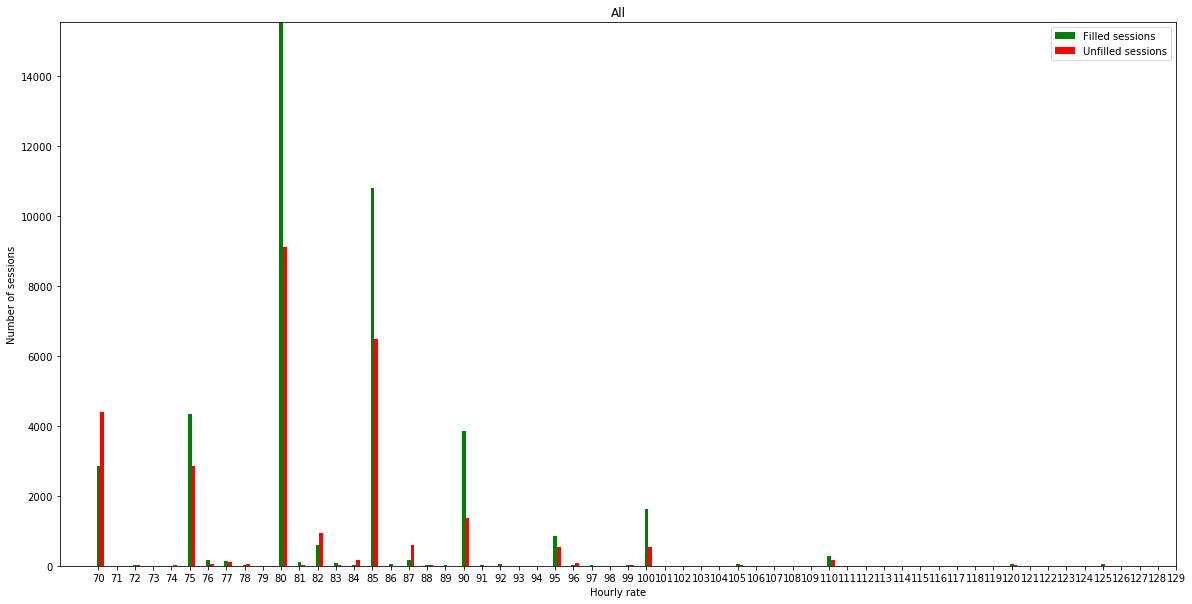

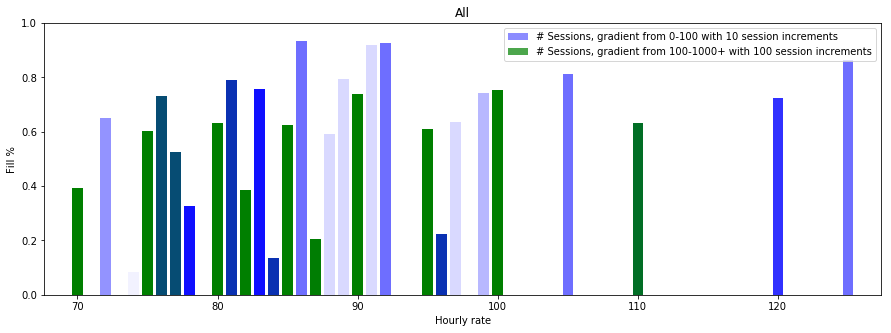

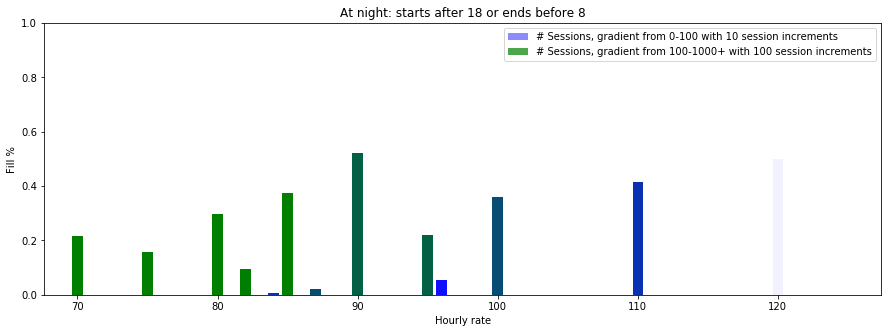

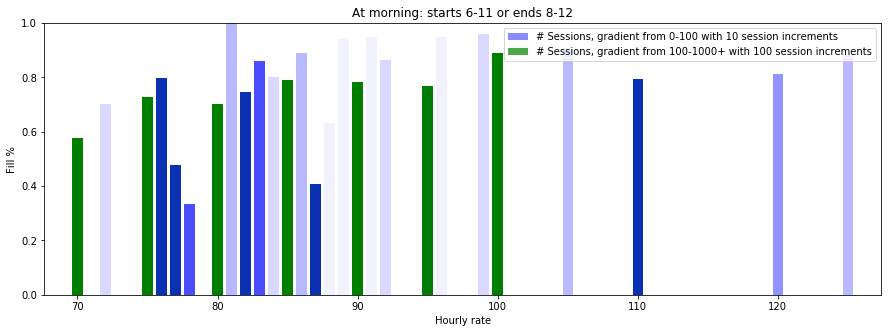

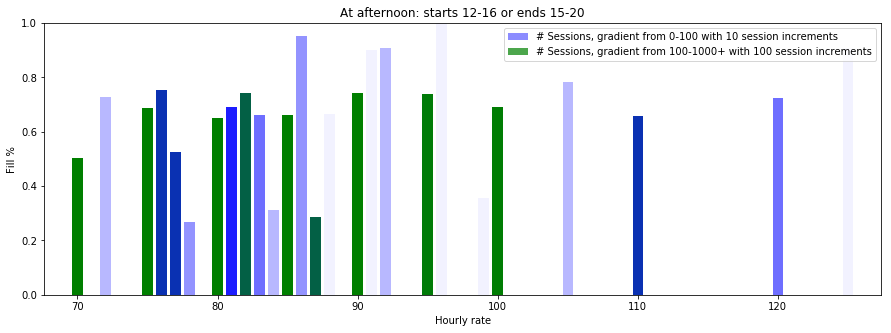

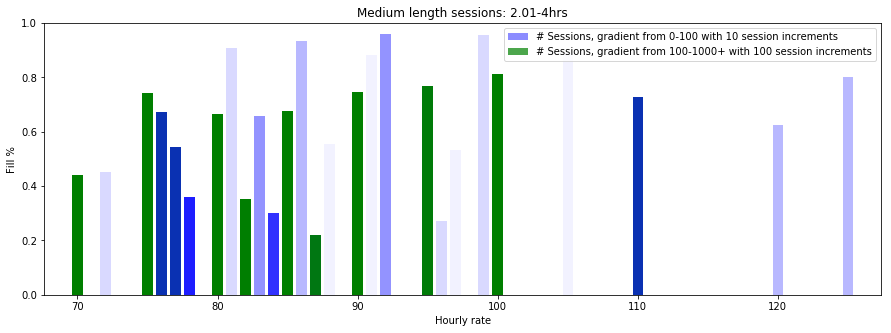

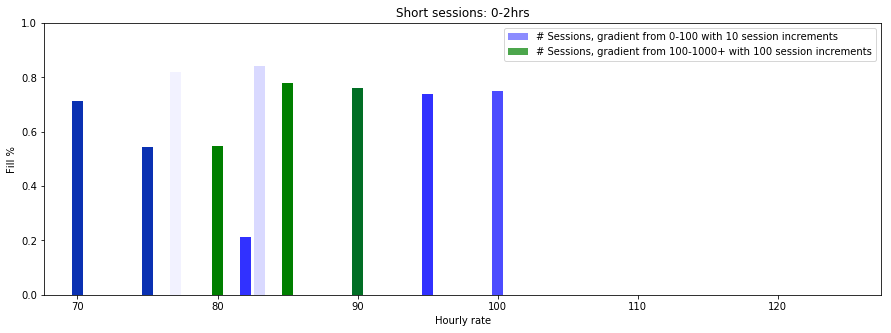

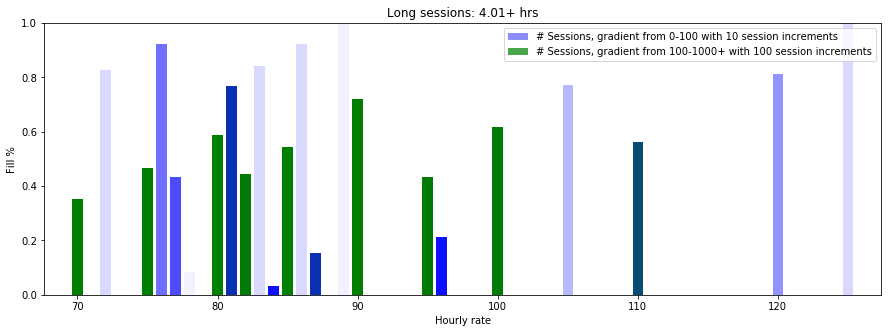

In [50]:
print_hourly_rate_graphs(clean_df, "All")

night_df = clean_df[clean_df['at_night'] == True]
print_hourly_rate_graphs(night_df, "At night: starts after 18 or ends before 8", print_count=False)
morning_df = clean_df[clean_df['at_morning'] == True]
print_hourly_rate_graphs(morning_df, "At morning: starts 6-11 or ends 8-12", print_count=False)
afternoon_df = clean_df[clean_df['at_afternoon'] == True]
print_hourly_rate_graphs(afternoon_df, "At afternoon: starts 12-16 or ends 15-20", print_count=False)

medium_df = clean_df[clean_df['is_medium'] == True]
print_hourly_rate_graphs(medium_df, "Medium length sessions: 2.01-4hrs", print_count=False)
short_df = clean_df[clean_df['is_short'] == True]
print_hourly_rate_graphs(short_df, "Short sessions: 0-2hrs", print_count=False)
long_df = clean_df[clean_df['is_long'] == True]
print_hourly_rate_graphs(long_df, "Long sessions: 4.01+ hrs", print_count=False)

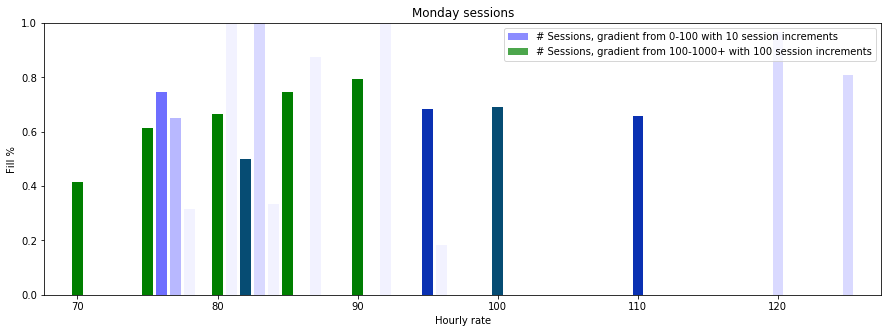

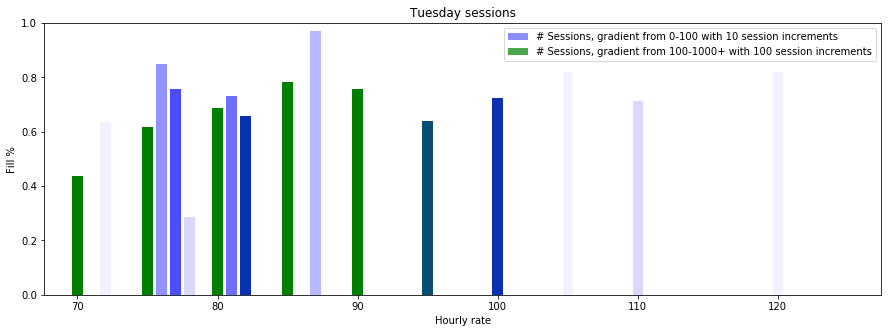

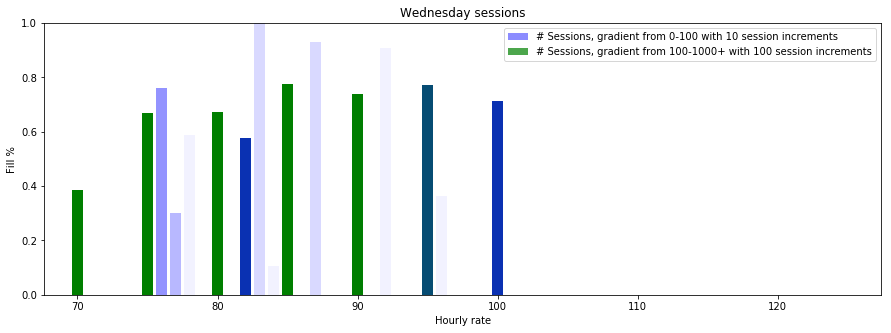

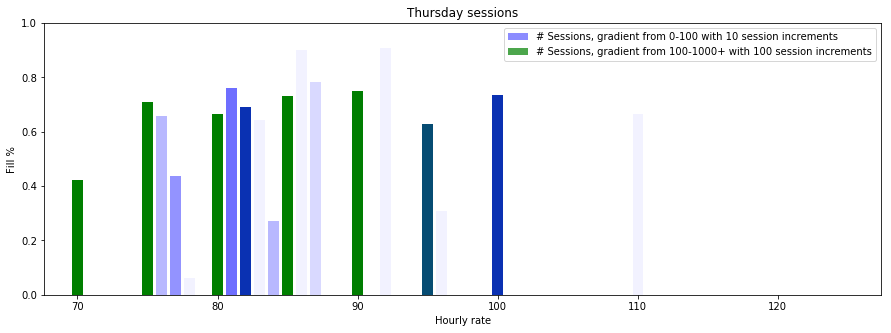

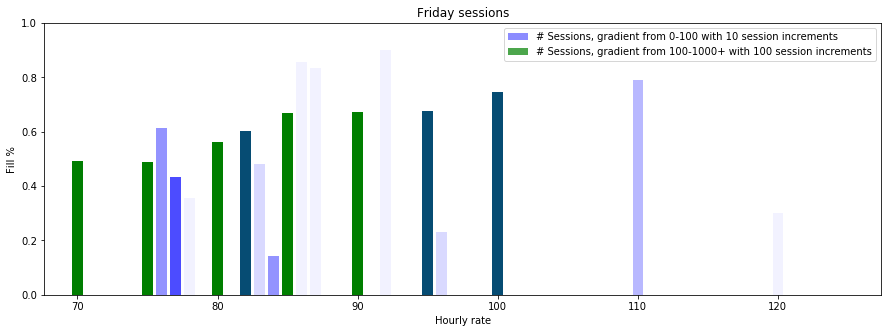

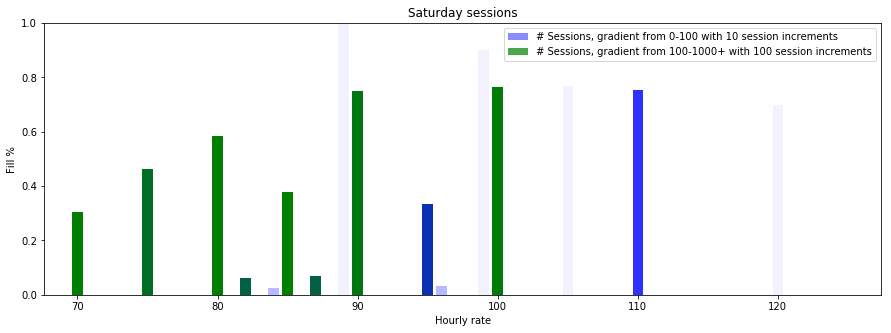

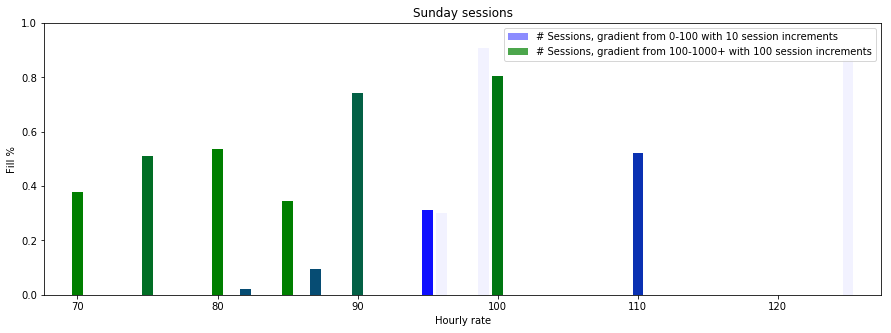

In [51]:
monday_df = clean_df[clean_df['monday'] == True]
print_hourly_rate_graphs(monday_df, "Monday sessions", print_count=False)
tuesday_df = clean_df[clean_df['tuesday'] == True]
print_hourly_rate_graphs(tuesday_df, "Tuesday sessions", print_count=False)
wednesday_df = clean_df[clean_df['wednesday'] == True]
print_hourly_rate_graphs(wednesday_df, "Wednesday sessions", print_count=False)
thursday_df = clean_df[clean_df['thursday'] == True]
print_hourly_rate_graphs(thursday_df, "Thursday sessions", print_count=False)
friday_df = clean_df[clean_df['friday'] == True]
print_hourly_rate_graphs(friday_df, "Friday sessions", print_count=False)
saturday_df = clean_df[clean_df['saturday'] == True]
print_hourly_rate_graphs(saturday_df, "Saturday sessions", print_count=False)
sunday_df = clean_df[clean_df['sunday'] == True]
print_hourly_rate_graphs(sunday_df, "Sunday sessions", print_count=False)